### Import function

In [1]:
from utilsclust import *
from score_utils import *

### Read answers

In [2]:
answers, answers_diffs = read_ans("/mnt/d/sharegit/MasterThesis_data/NeurosenseDB/PerceivedResponseAnswersheet.txt")

In [3]:
output = []
total_correct_counts = np.zeros((3, 4))  # To store total correct counts for each test and number
for folder_sub in range(1, 35):
    r_ex, r_chg, count_correct = score(f"/mnt/d/sharegit/MasterThesis_data/NeurosenseDB/sub-{folder_sub:02d}/other/sub-{folder_sub:02d}_R.tsv", answers, answers_diffs)
    folder_sub_output = [folder_sub]
    folder_sub_output.extend(summary(r_ex, r_chg, count_correct).tolist())  # Use extend to append values to the list
    output.append(folder_sub_output)
    total_correct_counts += count_correct

df_scores = pd.DataFrame(output, columns=["ID", "eAir", "eVib", "eCar", "eAll", "dAir", "dVib", "dCar", "dAll", 
                                          "a1", "a2", "a3", "a4", "v1", "v2", "v3", "v4", "c1", "c2", "c3", "c4"])
df_scores = df_scores[(df_scores != 0).all(axis=1)]
df_scores.reset_index(drop=True, inplace=True)
df_scores = summary_porcentage(df_scores)
df_scores = df_scores.set_index(list(df_scores)[0])

df_scores['a1'] = df_scores['a1'].div(17).mul(100)
df_scores['a2'] = df_scores['a2'].div(17).mul(100)
df_scores['a3'] = df_scores['a3'].div(17).mul(100)
df_scores['a4'] = df_scores['a4'].div(17).mul(100)

df_scores['v1'] = df_scores['v1'].div(20).mul(100)
df_scores['v2'] = df_scores['v2'].div(20).mul(100)
df_scores['v3'] = df_scores['v3'].div(20).mul(100)
df_scores['v4'] = df_scores['v4'].div(20).mul(100)

df_scores['c1'] = df_scores['c1'].div(20).mul(100)
df_scores['c2'] = df_scores['c2'].div(20).mul(100)
df_scores['c3'] = df_scores['c3'].div(20).mul(100)
df_scores['c4'] = df_scores['c4'].div(20).mul(100)

### Standarize data

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_clust_scaled = scaler.fit_transform(df_scores)

### Print the number of corrects per intensity

In [5]:
# Print out the counts of correct answers for each number and test
for test_idx, test_name in enumerate(['Air', 'Vib', 'Car']):
    print(f"Test {test_name}:")
    for num in range(1, 5):
        print(f"  Number {num} correct: {total_correct_counts[test_idx, num - 1]}")

Test Air:
  Number 1 correct: 377.0
  Number 2 correct: 335.0
  Number 3 correct: 382.0
  Number 4 correct: 476.0
Test Vib:
  Number 1 correct: 568.0
  Number 2 correct: 572.0
  Number 3 correct: 609.0
  Number 4 correct: 626.0
Test Car:
  Number 1 correct: 427.0
  Number 2 correct: 349.0
  Number 3 correct: 417.0
  Number 4 correct: 549.0


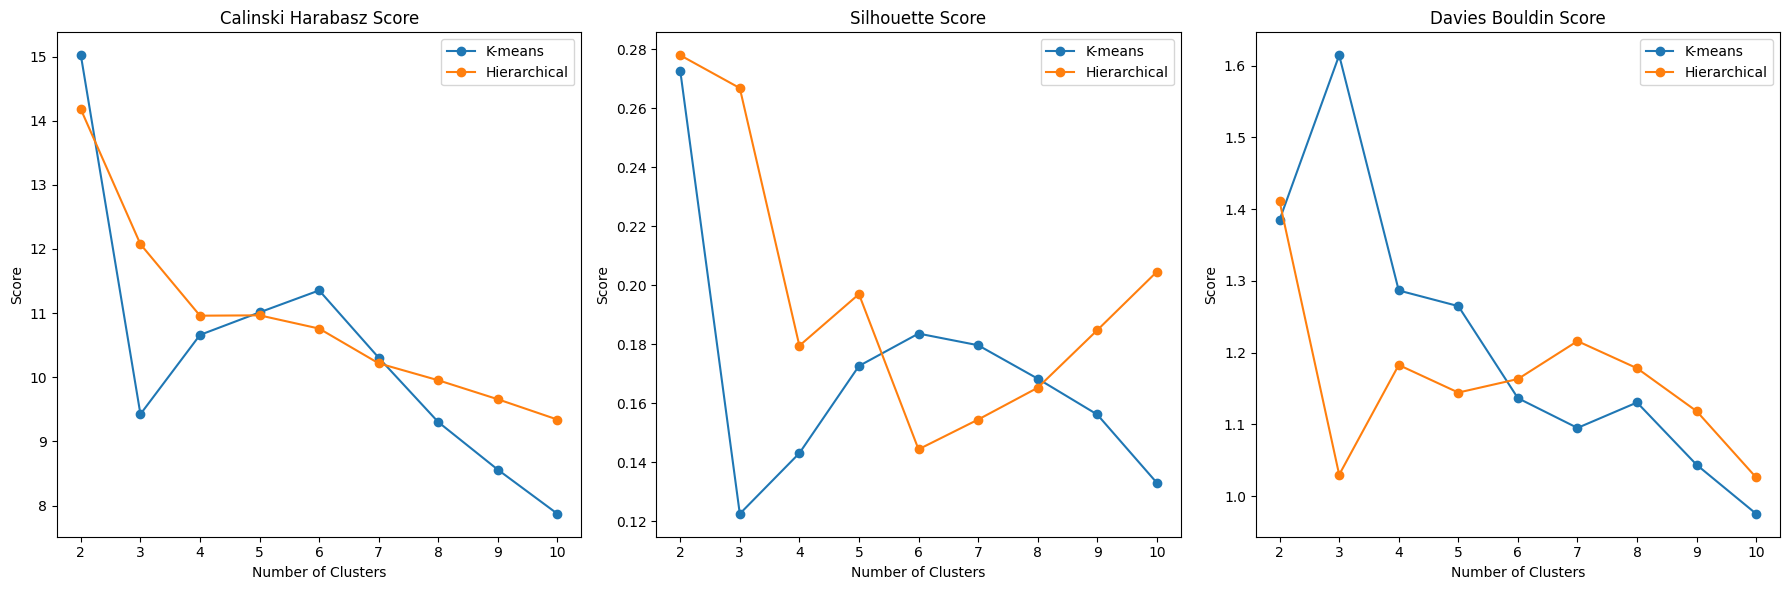

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

def plot_clust_metrics(df_clust_scaled, cluster_range=range(2, 11)):
    # Initialize lists to store the evaluation scores for each algorithm
    metrics = {
        'kmeans': {'calinski_harabasz': [], 'silhouette': [], 'davies_bouldin': []},
        'hierarchical': {'calinski_harabasz': [], 'silhouette': [], 'davies_bouldin': []}
    }

    # Calculate metrics for K-means and Hierarchical Clustering
    for method in ['kmeans', 'hierarchical']:
        for n_clusters in cluster_range:
            if method == 'kmeans':
                model = KMeans(n_clusters=n_clusters, random_state=42)
            elif method == 'hierarchical':
                model = AgglomerativeClustering(n_clusters=n_clusters)

            cluster_labels = model.fit_predict(df_clust_scaled)

            metrics[method]['calinski_harabasz'].append(calinski_harabasz_score(df_clust_scaled, cluster_labels))
            metrics[method]['silhouette'].append(silhouette_score(df_clust_scaled, cluster_labels))
            metrics[method]['davies_bouldin'].append(davies_bouldin_score(df_clust_scaled, cluster_labels))

    # Plotting the scores
    plt.figure(figsize=(18, 6))

    for idx, metric in enumerate(['calinski_harabasz', 'silhouette', 'davies_bouldin']):
        plt.subplot(1, 3, idx+1)

        plt.plot(cluster_range, metrics['kmeans'][metric], marker='o', label='K-means')
        plt.plot(cluster_range, metrics['hierarchical'][metric], marker='o', label='Hierarchical')

        plt.title(metric.replace('_', ' ').title() + ' Score')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Score')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_clust_metrics(df_clust_scaled, cluster_range=range(2, 11))


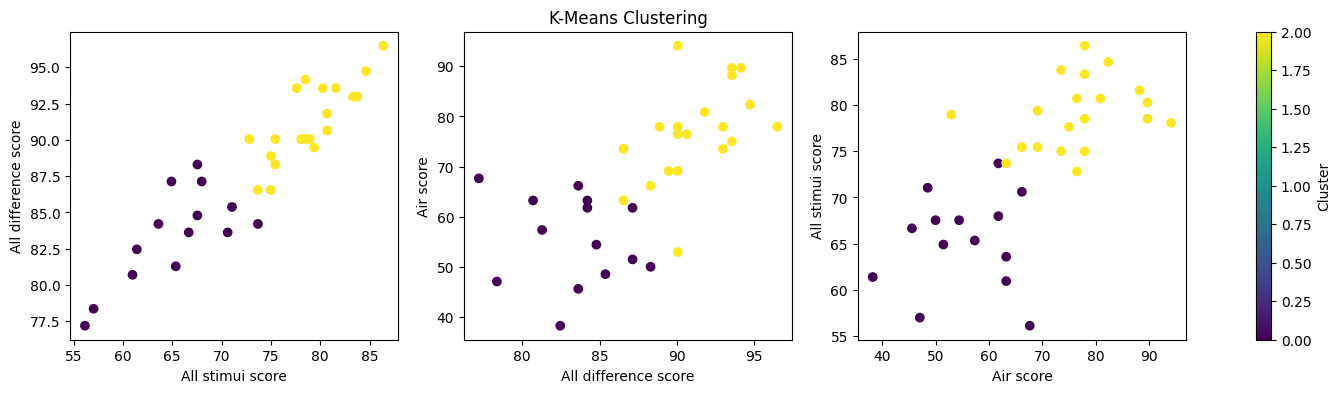

In [7]:
df_scores = plot_clusts(df_scores, df_clust_scaled, n_clusters = 2)

### Estimate the feature importance by using Random Forest Feature Importance 

In [8]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Prepare the data
y = df_scores['Cluster']
X = df_scores.drop(columns=['Cluster'])

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

   Feature  Importance
3     eAll    0.245140
0     eAir    0.168246
7     dAll    0.143111
4     dAir    0.059777
10      a3    0.055742
9       a2    0.050142
8       a1    0.045179
14      v3    0.043889
5     dVib    0.026717
16      c1    0.025084
17      c2    0.019523
11      a4    0.019446
1     eVib    0.017921
13      v2    0.017878
2     eCar    0.015611
12      v1    0.012806
6     dCar    0.011266
18      c3    0.008908
15      v4    0.007253
19      c4    0.006358


### Select the most important features > 0.1

In [9]:
df_scores_filt = df_scores[["eAll", "eAir", "dAll"]]
df_clust = df_scores_filt.copy()

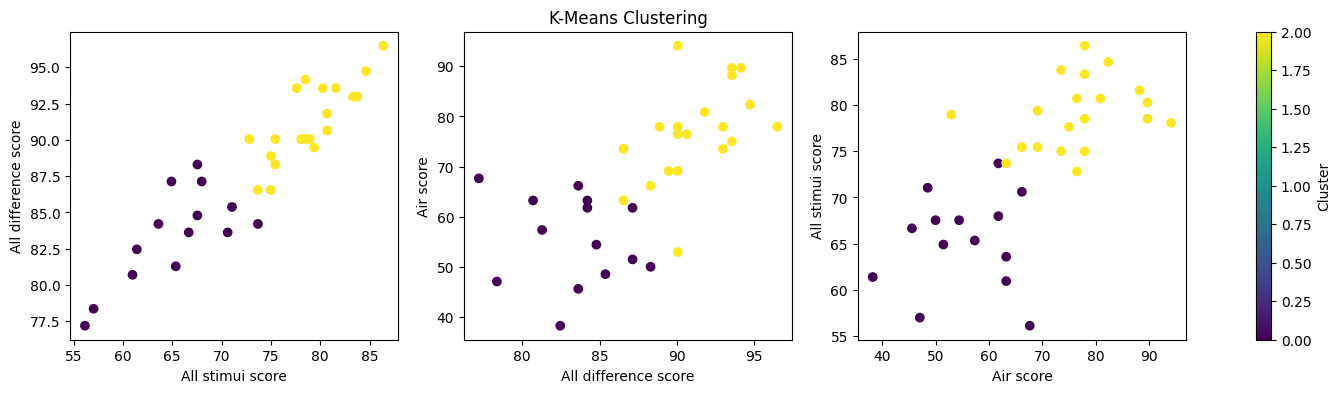

In [10]:
df_scores = plot_clusts(df_scores, df_clust_scaled, n_clusters = 2)

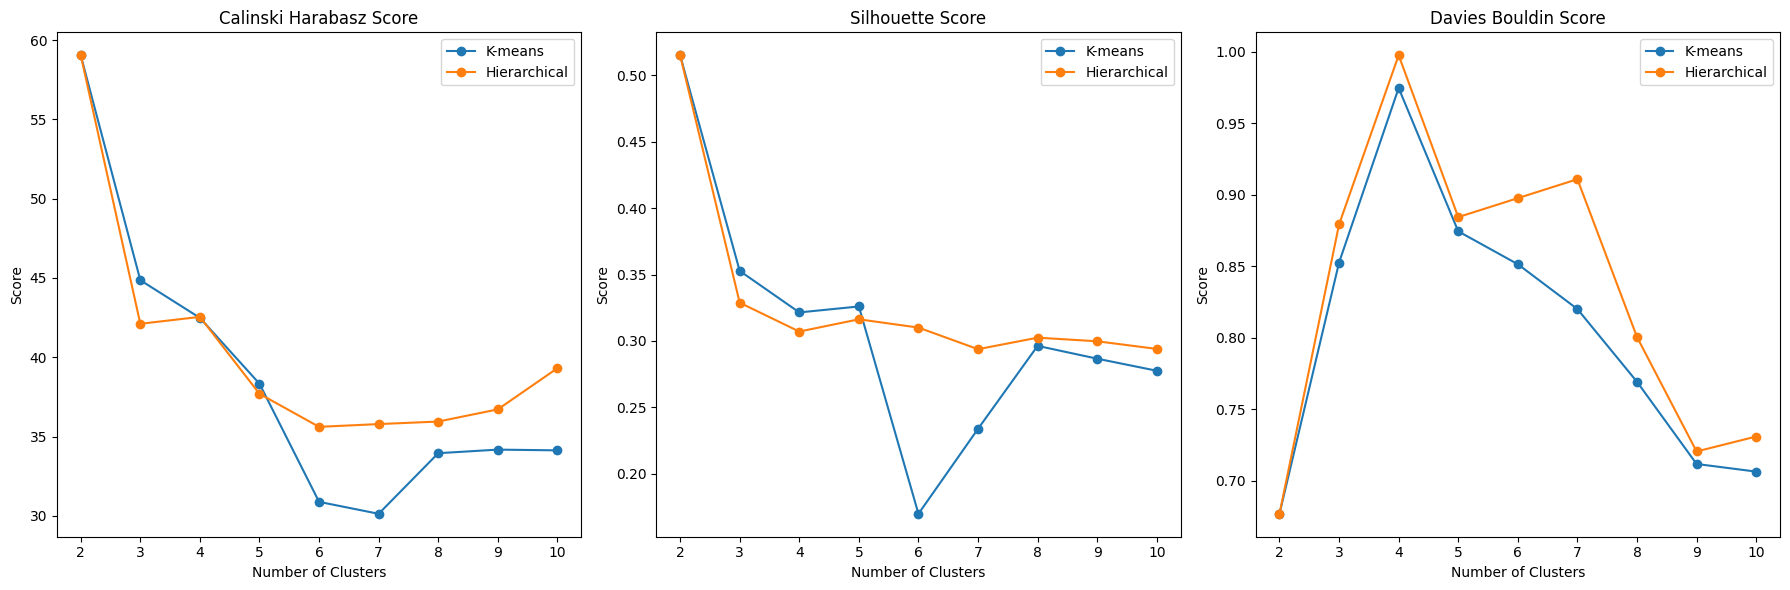

In [11]:
df_clust_scaled = scaler.fit_transform(df_clust)
plot_clust_metrics(df_clust_scaled)

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
df_clust_scaled = scaler.fit_transform(df_clust)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can change the number of clusters
kmeans.fit(df_clust_scaled)
df_scores['Cluster'] = kmeans.labels_

<Figure size 1600x1200 with 0 Axes>

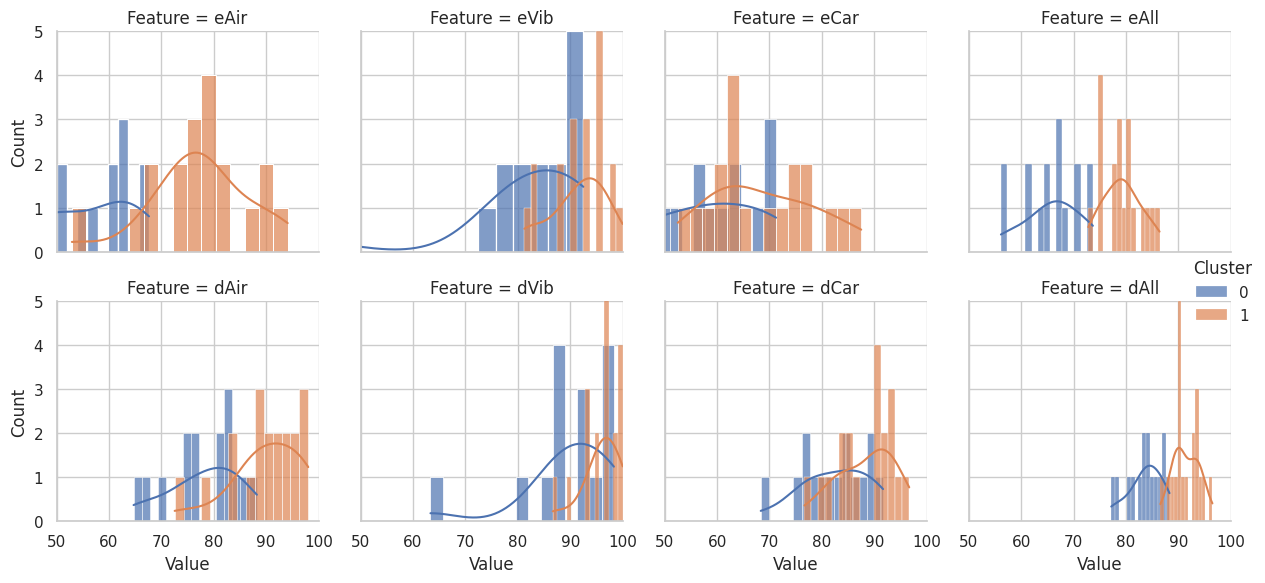

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select the first 8 columns and the cluster column
columns_to_plot = ['eAir', 'eVib', 'eCar', 'eAll', 'dAir', 'dVib', 'dCar', 'dAll']
df_to_plot = df_scores[columns_to_plot + ['Cluster']]

# Melt the dataframe to use with seaborn
df_melted = df_to_plot.melt(id_vars='Cluster', var_name='Feature', value_name='Value')

# Create the distribution plots
plt.figure(figsize=(16, 12))
sns.set(style="whitegrid")
g = sns.FacetGrid(df_melted, col="Feature", hue="Cluster", col_wrap=4, sharex=True, sharey=True)
g.map(sns.histplot, "Value", kde=True, bins=15, alpha=0.7).add_legend()

# Set x and y limits
for ax in g.axes.flat:
    ax.set_xlim(50, 100)
    ax.set_ylim(0, 5)

plt.tight_layout()
plt.show()

In [14]:
filename = '/mnt/d/sharegit/MasterThesis_data/DWTs/clustered_dataframe.csv'
df_scores.to_csv(filename)
df_scores

,eAir,eVib,eCar,eAll,dAir,dVib,dCar,dAll,a1,a2,...,a4,v1,v2,v3,v4,c1,c2,c3,c4,Cluster
ID,,,,,,,,,,,,,,,,,,,,,
1,47.058824,76.25,46.25,57.017544,64.705882,88.333333,80.000000,78.362573,35.294118,41.176471,...,70.588235,65.0,65.0,75.0,100.0,60.0,30.0,30.0,65.0,0
2,66.176471,88.75,56.25,70.614035,80.392157,91.666667,78.333333,83.625731,52.941176,58.823529,...,88.235294,85.0,85.0,90.0,95.0,45.0,40.0,70.0,70.0,0
3,50.000000,92.50,57.50,67.543860,76.470588,98.333333,88.333333,88.304094,35.294118,41.176471,...,70.588235,95.0,95.0,90.0,90.0,50.0,35.0,65.0,80.0,0
4,69.117647,92.50,63.75,75.438596,86.274510,100.000000,83.333333,90.058480,58.823529,58.823529,...,82.352941,90.0,85.0,95.0,100.0,55.0,55.0,65.0,80.0,1
5,61.764706,87.50,70.00,73.684211,74.509804,93.333333,83.333333,84.210526,41.176471,41.176471,...,88.235294,85.0,85.0,90.0,90.0,55.0,60.0,80.0,85.0,0
6,76.470588,87.50,77.50,80.701754,84.313725,96.666667,90.000000,90.643275,70.588235,76.470588,...,82.352941,95.0,95.0,80.0,80.0,75.0,75.0,70.0,90.0,1
7,63.235294,80.00,47.50,63.596491,88.235294,88.333333,76.666667,84.210526,58.823529,41.176471,...,94.117647,70.0,65.0,90.0,95.0,55.0,30.0,40.0,65.0,0
8,48.529412,90.00,71.25,71.052632,66.666667,95.000000,91.666667,85.380117,52.941176,29.411765,...,64.705882,90.0,85.0,90.0,95.0,55.0,55.0,85.0,90.0,0
9,75.000000,97.50,60.00,77.631579,94.117647,100.000000,86.666667,93.567251,64.705882,64.705882,...,88.235294,95.0,95.0,100.0,100.0,50.0,35.0,60.0,95.0,1
